# Постановка задачи

**Бизнес-постановка задачи**: разработать модель прогнозирования стоимости акций компании Apple (AAPL) на основе исторических данных

**Постановка ML-задачи**: прогнозирование временного ряда с использованием машинного обучения

Для решения поставленной задачи будет использоваться набор данных о стоимости акций Apple, который включает следующие столбцы:  
- Date: дата регистрации значения.
- Open: цена открытия акций в этот день.
- High: наивысшая цена акций за день.
- Low: наименьшая цена акций за день.
- Close: цена закрытия акций в этот день.
- Adj Close: скорректированная цена закрытия акций с учетом дивидендов и сплитов.
- Volume: объем торгов акциями.







**Загрузка данных**

https://drive.google.com/file/d/1pPDjRxO3AuQpazS9jXkvtoN2swxrsC-k/view?usp=sharing

https://www.kaggle.com/datasets/henryshan/apple-stock-price/data?select=AAPL.csv

**Импорты**

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
# Темная тема
sns.set_style("darkgrid")

In [5]:
# При локальной загрузке
df = pd.read_csv('./content/AAPL.csv')

# **2. Выбор метрики**

Для оценки качества модели прогнозирования цен акций Apple оптимально использовать метрику среднеквадратичной ошибки (MSE).

**Обоснование выбора метрики:**

Эта метрика позволяет измерить среднее квадратичное отклонение между предсказанными значениями и фактическими значениями, что особенно важно в контексте финансовых данных, где точность прогноза может существенно влиять на прибыль.




## 3. EDA

In [6]:
# Просмотр первых 5 строк
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099319,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094137,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087228,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089387,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091978,73449600


In [7]:
# Получение общей информации о наборе данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10836 non-null  object 
 1   Open       10836 non-null  float64
 2   High       10836 non-null  float64
 3   Low        10836 non-null  float64
 4   Close      10836 non-null  float64
 5   Adj Close  10836 non-null  float64
 6   Volume     10836 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 592.7+ KB


### Выводы о наборе данных:

- Дата (столбец Date) представлена как строка, что требует преобразования в тип datetime для корректной работы с временными рядами.
- Все остальные колонки имеют числовые типы данных, и отсутствующие значения не обнаружены, что является положительным моментом.
- Использование памяти относительно небольшое, что облегчает работу с данным набором.


In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
# Длина данных
len(df)

10836

In [10]:
# Просмотр нулевых значений
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
# Проверка на дубликаты и удаление, если есть

df.drop_duplicates(subset='Date', keep='first', inplace=True)

len(df)

10836

In [12]:
# Вычисление базовых статистик
stats = df.describe()
print(stats)

                                Date          Open          High  \
count                          10836  10836.000000  10836.000000   
mean   2002-06-01 02:18:04.385382144     19.783697     20.002122   
min              1980-12-12 00:00:00      0.049665      0.049665   
25%              1991-08-29 18:00:00      0.294643      0.301339   
50%              2002-05-29 12:00:00      0.508929      0.516183   
75%              2013-03-04 06:00:00     18.786697     18.965447   
max              2023-12-05 00:00:00    196.240005    198.229996   
std                              NaN     41.396815     41.861870   

                Low         Close     Adj Close        Volume  
count  10836.000000  10836.000000  10836.000000  1.083600e+04  
mean      19.574328     19.797366     19.045572  3.219041e+08  
min        0.049107      0.049107      0.038000  0.000000e+00  
25%        0.287332      0.294643      0.241206  1.164436e+08  
50%        0.500000      0.508371      0.417317  2.094288e+08  
75%

### Анализ базовых характеристик данных

- Количество наблюдений (count):
  - Все столбцы содержат 10,836 наблюдений, что указывает на полный набор данных без отсутствующих значений

- Цены (Open, High, Low, Close, Adj Close):
  - Средние значения:
    - Средняя цена открытия составляет → 19.78
    - Средняя цена закрытия составляет → 19.80
  - Стандартные отклонения:
    - Значительное стандартное отклонение (41.40 для открытия, 41.43 для закрытия) указывает на высокую волатильность цен акций Apple, что является характерным для финансовых рынков
  - Минимальные и максимальные значения:
    - Минимальная цена открытия составляет → 0.0497, а максимальная — 196.24, что показывает исторически низкие цены акций, вероятно, в начале 1980-х, и их быстрый рост за указанный период
  
- Объём торгов (Volume):
  - Средний объём торгов составляет → 322 млн акций, однако с значительным стандартным отклонением (336 млн)
  - Наблюдается большой диапазон между минимальным (0) и максимальным значением (7.4 млрд), что может свидетельствовать о нестабильных торговых периодах или о том, что в некоторые дни не было торгуемых акций




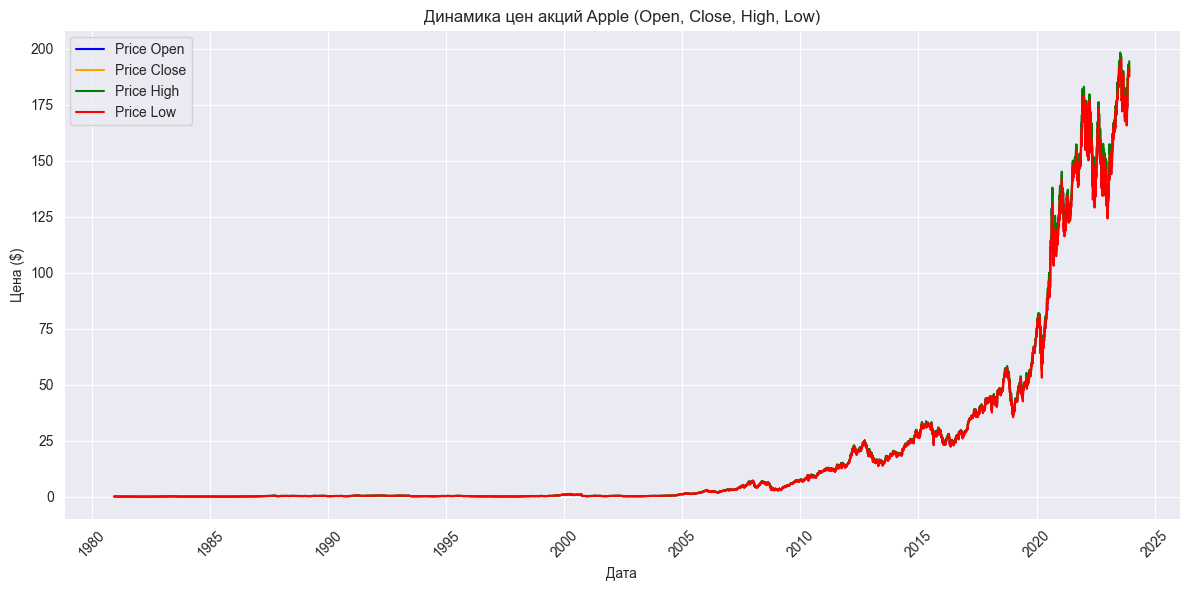

In [13]:
# Создание графика
plt.figure(figsize=(12, 6))

# Визуализация цены открытия, закрытия, максимума и минимума
sns.lineplot(x='Date', y='Open', data=df, label='Price Open', color='blue')
sns.lineplot(x='Date', y='Close', data=df, label='Price Close', color='orange')
sns.lineplot(x='Date', y='High', data=df, label='Price High', color='green')
sns.lineplot(x='Date', y='Low', data=df, label='Price Low', color='red')

plt.title('Динамика цен акций Apple (Open, Close, High, Low)')
plt.xlabel('Дата')
plt.ylabel('Цена ($)')
plt.legend()
plt.xticks(rotation=45)  # Поворот подписей по оси X для лучшей читаемости
plt.tight_layout()  # Автоматическая подстройка границ графика

# Показать график
plt.show()


График изменения цены закрытия акций показывает, что с 1980 года цена стремительно росла, с явными тенденциями роста, особенно в последние годы. Это указывает на растущий интерес к акциям Apple и может служить основой для разработки инвестиционных стратегий

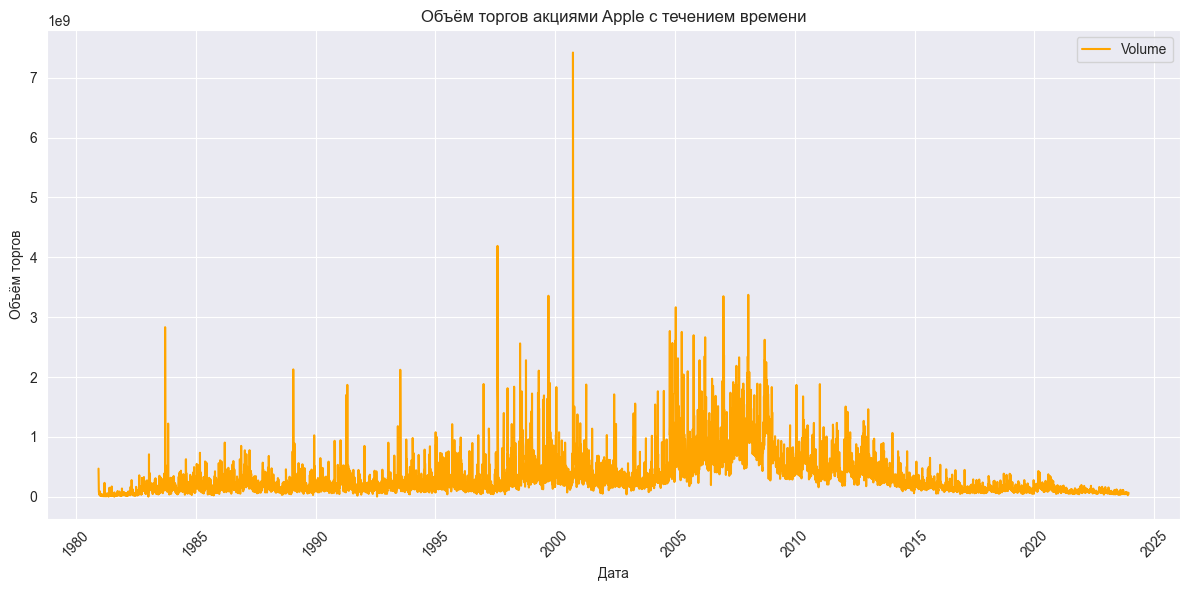

In [14]:
plt.figure(figsize=(12, 6))

# Визуализация объёма торгов с использованием Seaborn
sns.lineplot(x='Date', y='Volume', data=df, color='orange', label='Volume')

# Установка заголовков и меток
plt.title('Объём торгов акциями Apple с течением времени')
plt.xlabel('Дата')
plt.ylabel('Объём торгов')
plt.xticks(rotation=45)  # Поворот подписей по оси X для лучшей читаемости
plt.legend()
plt.tight_layout()  # Автоматическая подстройка границ графика

# Показать график
plt.show()

Объём торгов демонстрирует пиковые значения в определённые периоды, совпадая с событиями, такими как релизы новых продуктов Apple или экономические кризисы. Это может быть использовано для понимания волатильности и ликвидности акций

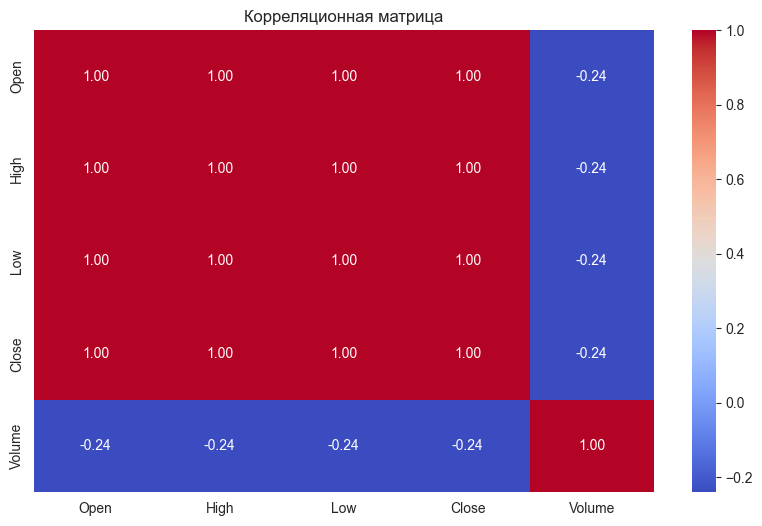

In [15]:
# Корреляция между различными ценами и объёмом
plt.figure(figsize=(10, 6))
correlation = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

Корреляционная матрица показывает высокую положительную корреляцию между ценами открытия, закрытия, максимальными и минимальными ценами. Это указывает на то, что эти переменные ведут себя довольно одинаково, что полезно при выборе функций для модели машинного обучения.

Рекоммендации для дальнейшего анализа:
- Создание новых признаков: Рассмотреть возможность создания дополнительных признаков, таких как скользящие средние, индикаторы объёма или изменения в ценах, чтобы улучшить модель.
- Разделение данных: Важно разделить набор данных на обучающую и тестовую выборки для эффективного обучения и оценки модели.